In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from huggingface_hub import login, whoami

login()

In [25]:
# DATASET CONFIG
DATASET='sentence-transformers/trivia-qa-triplet'
MODEL='Alibaba-NLP/gte-modernbert-base'
MIN_TOKENS=50
MAX_TOKENS=8000
SAMPLES=10_000
MAX_VUS = 2000
TEXT_COLUMN='positive'
DATASET_PATH='data/dataset.json'
# K6_BIN = "/usr/bin/k6"
K6_BIN = "~/.local/bin/k6-sse"

HUB_DATASET_PATH = f'{whoami()["name"]}/embedding-ie-optimization'

In [26]:
from datasets import load_dataset
from transformers import AutoTokenizer
from src.process_dataset import tokenize_and_filter, sample_dataset, save_dataset

dataset = load_dataset(DATASET, 'triplet', split='train')

tokenizer = AutoTokenizer.from_pretrained(MODEL)

dataset = tokenize_and_filter(dataset, tokenizer, text_column=TEXT_COLUMN, num_proc=8)
dataset = sample_dataset(dataset, n_samples=SAMPLES, min_tokens=MIN_TOKENS, max_tokens=MAX_TOKENS, seed=42)
save_dataset(dataset.select_columns([TEXT_COLUMN]), DATASET_PATH)

2025-01-26 11:24:00.480 | SUCCESS  | src.process_dataset:sample_dataset:31 - Sampled dataset down to 10000 samples
2025-01-26 11:24:00.536 | SUCCESS  | src.process_dataset:save_dataset:44 - Saved dataset to data/dataset.json


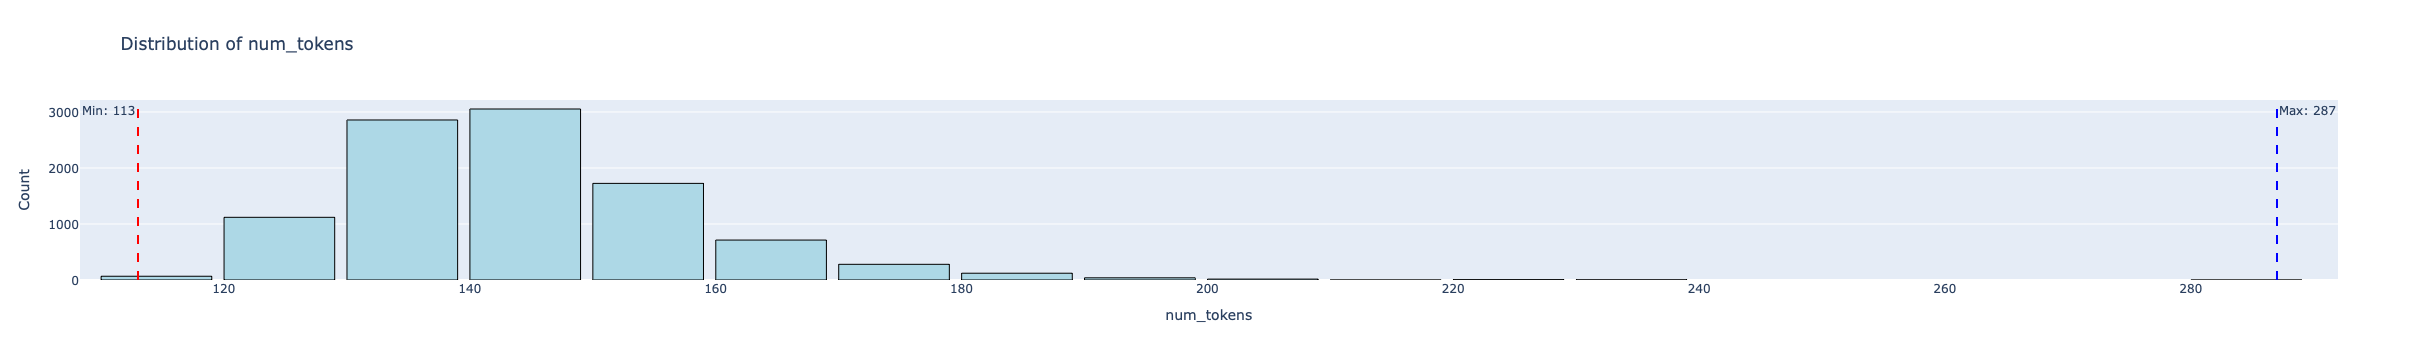

In [27]:
import plotly.graph_objects as go
from IPython.display import display, HTML
import base64
import json

num_tokens = dataset.to_pandas()['num_tokens']

# Create histogram
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=num_tokens,
    nbinsx=30,  # Adjust number of bins as needed
    marker=dict(color="lightblue", line=dict(color="black", width=1))
))

# Add vertical lines for min and max values
min_val = num_tokens.min()
max_val = num_tokens.max()

fig.add_vline(x=min_val, line=dict(color="red", dash="dash"), annotation_text=f"Min: {min_val}", annotation_position="top left")
fig.add_vline(x=max_val, line=dict(color="blue", dash="dash"), annotation_text=f"Max: {max_val}", annotation_position="top right")

# Update layout
fig.update_layout(
    title="Distribution of num_tokens",
    xaxis_title="num_tokens",
    yaxis_title="Count",
    bargap=0.1
)

# Show plot
fig.show()

fig_json = fig.to_json()

# Encode data
encoded_data = base64.b64encode(json.dumps({"fig_json": fig_json}).encode()).decode()

code = f'''
<html>
	<head>
		<script type="module" crossorigin src="https://cdn.jsdelivr.net/npm/@gradio/lite/dist/lite.js"></script>
	</head>
	<body>
		<gradio-lite>
        import json, gradio as gr, base64, plotly.io as pio

        encoded_data = "{encoded_data}"
        decoded_data = json.loads(base64.b64decode(encoded_data).decode())

        fig = pio.from_json(decoded_data["fig_json"])

        with gr.Blocks() as demo:
            gr.Markdown("# Token Distribution")
            gr.Plot(fig, label="Histogram of num_tokens")

        demo.launch()
        </gradio-lite>
	</body>
</html>
'''

display(HTML(code))



In [41]:
from dataclasses import dataclass, field, asdict
from typing import Dict

@dataclass
class InstanceConfig:
    repository: str
    accelerator: str
    instance_size: str
    instance_type: str
    custom_image: Dict[str, str]  # Dict of str -> str
    vendor: str
    region: str

@dataclass
class InfinityConfig:
    INFINITY_PORT: str = "80"
    INFINITY_ENGINE: str = "torch"
    INFINITY_BATCH_SIZE: str = "16"
    INFINITY_DTYPE: str = "auto"
    INFINITY_EMBEDDING_DTYPE: str = "float32"
    INFINITY_POOLING_METHOD: str = "auto"
    INFINITY_COMPILE: str = 'false'
    INFINITY_BETTERTRANSFORMER: str = 'false'
    INFINITY_MODEL_ID: str = "/repository"

    def to_dict(self) -> Dict[str, str]:
        """Converts the dataclass to a dictionary representation."""
        return asdict(self)

@dataclass
class ImageConfig:
    health_route: str = "/health"
    url: str = "michaelf34/infinity:0.0.75-trt-onnx"
    env: InfinityConfig = field(default_factory=InfinityConfig)


In [42]:
def set_env(batch_size: int, image_config: ImageConfig) -> Dict[str, str]:
    config = asdict(image_config)
    config['env']["INFINITY_BATCH_SIZE"] = str(batch_size)
    return config

# Experiments

In [43]:
from src.deployment import deploy_endpoint
?deploy_endpoint

Signature: deploy_endpoint(instance_config, endpoint_name, wait=False)
Docstring: Creates and deploys an inference endpoint using the given instance configuration.
File:      ~/projects/encoder-analysis/src/deployment.py
Type:      function

## GPUs

In [47]:
instance_config_experiment_dicts = [
    # {
    #     'accelerator': 'gpu',
    #     'instance_size': 'x1',
    #     'instance_type': 'nvidia-l4',
    #     'vendor': 'gcp',
    #     'region': 'us-east4',
    # },
    # {
    #     'accelerator': 'gpu',
    #     'instance_size': 'x1',
    #     'instance_type': 'nvidia-t4',
    #     'vendor': 'aws',
    #     'region': 'us-east-1',
    # },
    {
        'accelerator': 'gpu',
        'instance_size': 'x1',
        'instance_type': 'nvidia-l4',
        'vendor': 'aws',
        'region': 'us-east-1',
    },
]
instance_config_experiments = [InstanceConfig(repository=MODEL, **instance_config_experiment_dict, custom_image=None) for instance_config_experiment_dict in instance_config_experiment_dicts]

In [48]:
import copy
from pathlib import Path
from time import sleep

from loguru import logger

from src.k6 import call_k6, optimal_vus

template_file = "embedding-analysis.js.j2"
output_file = Path("./generated").resolve()/"embedding-analysis.js"

start_vus = 32
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]

for og_instance_config_experiment in instance_config_experiments:
    endpoints = []
    for batch_size in batch_sizes:
        # Configure Infinity Settings, pass them up to the image
        infinty_config = InfinityConfig(INFINITY_BATCH_SIZE=str(batch_size))
        image_config = ImageConfig(env=infinty_config)

        # Add the image to the HW instance
        instance_config_experiment = copy.deepcopy(og_instance_config_experiment)
        instance_config_experiment.custom_image = image_config

        # Deploy the endpoint
        logger.info(f'Creating endpoint with Batch Size:\t{batch_size}')
        vendor = instance_config_experiment.vendor
        endpoint = deploy_endpoint(instance_config_experiment, endpoint_name=f'ea-{vendor}-{batch_size}', wait=False)
        endpoints.append(endpoint)

    endpoints[0].wait()
    
    for endpoint in endpoints:
        endpoint.fetch()
        batch_size = endpoint.__dict__["raw"]["model"]["env"]["INFINITY_BATCH_SIZE"]
        vendor = endpoint.__dict__["raw"]["provider"]["vendor"]
        instance_type = endpoint.__dict__["raw"]["compute"]["instanceType"]
        logger.success(f'Endpoint is ready!')
        logger.info(f'\tVendor: {vendor}')
        logger.info(f'\tInstance: {instance_type}')
        logger.info(f'\tBatch Size: {batch_size}')

        args_dict = dict(
            endpoint=endpoint,
            total_requests=10_000,
            template_file=template_file,
            output_file=output_file,
            dataset_path=DATASET_PATH,
            k6_bin=K6_BIN
        )

        optimal_vus(max_vus=MAX_VUS, args_dict=args_dict, start_vus=start_vus)
        endpoint.delete()
        sleep(5)

2025-01-26 16:58:32.990 | INFO     | __main__:<module>:27 - Creating endpoint with Batch Size:	16
2025-01-26 16:58:34.161 | SUCCESS  | src.deployment:deploy_endpoint:15 - Re-using Endpoint: hw=nvidia-l4	bs=16	
2025-01-26 16:58:34.162 | INFO     | __main__:<module>:27 - Creating endpoint with Batch Size:	32
2025-01-26 16:58:35.078 | SUCCESS  | src.deployment:deploy_endpoint:15 - Re-using Endpoint: hw=nvidia-t4	bs=32	
2025-01-26 16:58:35.079 | INFO     | __main__:<module>:27 - Creating endpoint with Batch Size:	64
2025-01-26 16:58:36.075 | SUCCESS  | src.deployment:deploy_endpoint:15 - Re-using Endpoint: hw=nvidia-t4	bs=64	
2025-01-26 16:58:36.077 | INFO     | __main__:<module>:27 - Creating endpoint with Batch Size:	128
2025-01-26 16:58:36.690 | SUCCESS  | src.deployment:deploy_endpoint:15 - Re-using Endpoint: hw=nvidia-t4	bs=128	
2025-01-26 16:58:36.692 | INFO     | __main__:<module>:27 - Creating endpoint with Batch Size:	256
2025-01-26 16:58:37.788 | SUCCESS  | src.deployment:deploy_

In [ ]:
from src.process_dataset import load_json_files

# Define cost per hour considering both hardware type and vendor
cost_per_hour = {
    ('gcp', 'nvidia-t4'): 0.5,
    ('gcp', 'nvidia-l4'): 0.7,
    ('aws', 'nvidia-t4'): 0.5,
    ('aws', 'nvidia-l4'): 0.8,
}

# Load dataset
df = load_json_files('results')

# Compute cost
df['seconds_per_billion'] = 1e9 / df['throughput_req_per_sec']
df['cost_per_sec'] = df.apply(lambda row: cost_per_hour.get((row['vendor'], row['hw_type']), 0) / 3600, axis=1)
df['1B_cost'] = df['seconds_per_billion'] * df['cost_per_sec']

df.sort_values(by='1B_cost').head()

In [ ]:
from datasets import Dataset
# Push to the hub
dataset = Dataset.from_pandas(df)
dataset.push_to_hub(HUB_DATASET_PATH)